Import usefull libreries

In [1]:
from igraph import *
import numpy as np
from math import floor
from random import randint
from operator import itemgetter, attrgetter
from datetime import date
from time import localtime, strftime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Define the functions to perform the attacks:

In [2]:
# a function to generate the "robust version" of a given graph g
# according to the Barabasi algorithm
# see http://barabasi.com/networksciencebook/chapter/8#buildin-robustness
#     http://barabasi.com/networksciencebook/chapter/8#advanced-8g
def robust_graph(g):
    # compute coefficient A
    g_avg_d = mean(g.degree())
    A = ((2 * g_avg_d ** 2 * (g_avg_d-1)**2) / (2*g_avg_d-1)) ** (float(1)/3)
    g_N = g.vcount()
    
    # compute kmax and kmin according to A
    kmax = int(round(A * (g_N ** (float(2)/3))))
    kmin_low = int(floor((g_N * g_avg_d - kmax) / (g_N - 1)))
    
    # as kmin will be rounded, balance nodes with kmin_low and kmin_low+1 to keep
    # the total number of links and avg degree of the original graph
    rem = ((g_N * g_avg_d - kmax) / (g_N - 1)) - kmin_low
    # 1-rem% of nodes must have degree kmin_low, the rest kmin_low+1
    
    # create the degree sequence to generate the graph
    n_low = int(round((g_N-1) * (1-rem)))
    n_high = (g_N-1) - n_low
    seq_deg_low = [kmin_low for i in range(0,n_low)]
    seq_deg_high = [kmin_low+1 for i in range(0,n_high)]
    seq_deg = seq_deg_high + seq_deg_low
    seq_deg.insert(0,kmax)
    
    # create the "robust" graph
    try:
        g_rob = Graph.Degree_Sequence(seq_deg, method="vl")
        print ("Robust graph generated with method \"vl\"")
    except:
        try:
            g_rob = Graph.Degree_Sequence(seq_deg, method="no_multiple")
            print ("Robust graph generated with method \"no_multiple\"")
        except:
            g_rob = Graph.Degree_Sequence(seq_deg, method="simple")
            print ("Robust graph generated with method \"simple\"")

    return g_rob

In [7]:
# set of functions to actually perform the attacks

DEBUG = True
GRANUL = 1000
DECIMALS = 4
COMMUNITY_DET_DEG = 20 #20->109 nodi

# these two lists are used to identify the set of attacks that we want to perform
sim_attacks = ["targ_deg_sim"]
seq_attacks = ["random", "targ_deg_seq"]
supported_attacks = sim_attacks + seq_attacks

# the list of nodes to attack in case of simultaneous attacks of type att_type
# assumes that vertices have a name, and returs the list of vertices to be attacked, by name, in order of attack
def attack_list(g, att_type):
    # 1. vert_cent[] must be a list of 2-tuples, e.g., [(1,2),(5,10),...]
    # 2. Each element corresponds to a node in the graph
    # 3. The first element of each tuple must be the NAME of the node
    # 4. The second element must be the centrality index corresponding to the particular attack we want to do
    #    (e.g., it must be degree of that node, in case we want to attack based on the degree)
    vert_cent = []
    
    ###aggiungo module based attack
    if att_type == "module_based":        
        ###se module_based, va ristretto il giant component perchè il calcolo della betweenness va fatto 
        ###su un numero ristretto di nodi
        g_clust = g.clusters(mode = "WEAK")
        print("nr of clusters: " + str(len(g_clust)) + ", dimension: " + str(g_clust.sizes()))
        g_GC = g_clust.giant()
        print(g_GC.degree())
        
        ###1 extract communities, 2 attack nodes, 3 make a list 
        ###with nodes that participates in inter community connections
        ###ritorna una lista di nomi di nodi inter community
        intercomm_nodes_list = intercommunity_nodes_list(g)
        
        ###4 betweennness fatta sui nodi
        ###popolo vert_cent[] con le tuple date dal nome dei vertici e rispettive betweenness
        ###lo faccio una volta sola su tutti i vertici del sottografo passato        
        for x in intercomm_nodes_list:
            ###ATTENZIONE:VARIAZIONE DALL'ALGORITMO!!
            ###problemi di performance nel caso di reti robuste
            #kill_node = g.vs.select(name_eq = x)
            #tuple = (x, round(g.betweenness(kill_node[0].index), DECIMALS))
            
            ###inserisco un peso random come se fosse il valore di betweenness in modo da
            ###non modificare l'algoritmo: a caso verrà scelto il nodo da attaccare per primo
            tuple = (x, randint(0,1000000))
            
            print(tuple)
            vert_cent.append(tuple)
            ###5 sta a riga 59 (for kill_name in kill_list)
            
    # ADD CODE HERE: add code to generate the list of vertices according to the to-be-performed sim attacks
    if att_type == "targ_deg_sim":    
        # ADD CODE HERE: add here the code to generate vert_cent for targ_deg_sim
        ###popolo vert_cent[] con le tuple date dal nome dei vertici e i rispettivi gradi
        for x in g.vs():
            tuple = (x["name"], g.degree(x.index))
            #print(tuple)
            vert_cent.append(tuple)

    # ADD CODE HERE: sort by the centrality metric in decreasing order
    # vert_cent[] must be sorted by the values of the second elements of the tuples, in decreasing order
    # to do so, look at how to sort structured elements here
    # https://docs.python.org/2/howto/sorting.html?highlight=sort#operator-module-functions
    
    ###ordino vert_cent[] in modo decrescente rispetto al grado/betweenness
    vert_cent = sorted(vert_cent, key=itemgetter(1), reverse=True)
    #print (vert_cent)
    
    # no need to kill the last node
    del vert_cent[-1]
    
    # ADD CODE HERE:
    # kill_names must be a list of vertices names, in order of killing
    kill_names = []
    ###assegno alla variabile kill_names i nomi dei nodi da attaccare
    kill_names = [x[0] for x in vert_cent]
    
    return kill_names


def intercommunity_nodes_list(g):
    ###nel caso del grafo robusto c'è un giant e tanti nodi di grado da 4 in giù
    idx = np.argwhere(np.array(g.degree())>=COMMUNITY_DET_DEG).flatten()
    sub_g1 = g.induced_subgraph(idx)

    # Fastgreedy algorithm
    vd = sub_g1.community_fastgreedy()

    # The number of detected communities
    print("Numero di comunità: " + str(vd.optimal_count))

    # convert to a cluster object to access additional information
    vd_clust = vd.as_clustering()

    # identify the indices of edges that cut across different communities
    cros = np.array(vd_clust.crossing())
    edge_inter_community = np.argwhere(cros == True).flatten()
    print("edge_inter_community:" + str(edge_inter_community))
    
    ###uso il set per eliminare eventuali duplicati
    nodes_inter_community = set()
    
    ###6 counterpart is skipped from the list
    for edge in edge_inter_community:
        print("(source,target):" + str(sub_g1.es[edge].tuple))
        source_vertex = sub_g1.es[edge].source_vertex
        target_vertex = sub_g1.es[edge].target_vertex
        ###scelgo di cancellare solo il source vertex
        nodes_inter_community.add(source_vertex['name'])
    
    print(len(nodes_inter_community))
    ###in base al vertice del sottografo vedo se appartiene
    ###a uno dei capi dell'edge da distruggere
    #     for v in sub_g1.vs:
    #         ###cerco gli archi del nodo v
    #         incident_edges = sub_g1.incident(v)
    #         print("incident_edges di " + str(v.index) + ": " + str(incident_edges))
    #         ###controllo se è presente negli edge del mio nodo almeno uno di quelli inter-community
    #         elems_in_both_lists = set(incident_edges) & set(edge_inter_community)
    #         print(elems_in_both_lists)
    #         if not elems_in_both_lists:
    #             sub_g1.delete_vertices(v.index)
    #             print("cancellato:" + str(v.index))
    #         else:
    #             ###
    #             pass   
            
    return list(nodes_inter_community)

# executes an attack of type att_type pattern until no node is left, and returns the list of GC proportions
# with respect to the original graph
# the output of the function is the variable GC_frac, which is
# - a list of tuples
# - each tuple being in the form (fraction of removed vertices, fraction of vertices still in the GC)
# This is the output of the attack, which will be used to plot the curves to identify the critical thresholds
# and the robustness properties
def attack(g_orig, att_type):
    
    # check that the attack can be done
    if att_type not in supported_attacks:
        print ("Attack " + att_type + " is not supported")
        return None

    # deepcopy to avoid modifications to the original graph
    g = deepcopy(g_orig)
    
    # prepare for the output list
    initial_size = g.vcount()
    GC_frac = [(0,1)]
    
    # count the # of killed vertices
    killed = 0
    
    # simultaneous attacks
    if att_type in sim_attacks:
        # must refer to vertices by name, as indexes are recomputed after each deletion
        for idx in range(0,g.vcount()):
            g.vs[idx]["name"] = str(idx)
            
        # get the ordered list of vertices to kill (as a list of vertex names)
        kill_list = attack_list(g, att_type)
    
        for kill_name in kill_list:
            ## ADD CODE HERE:
            # we have the list of nodes to kill in kill_names, so:
            
            ## 4. we insert a new point in the list GC_frac
            #    NB: if you have two INTEGERS a and b with a<b and you compute c = a/b, by default
            #        the RESULT WILL BE 0. To make sure that c is a real value, either a or b must be
            #        converted to real first, e.g. c = float(a)/b
            # NOTE: THINK WHY WE NEED TO IDENTIFY NODES BY NAME IN THE kill_list, AND NOT BY THEIR IDs
            
            #print ("ADD CODE HERE")
            
            #1. for each node to kill, we need to get its ID
            kill_node = g.vs.select(name_eq = kill_name)
            kill_id = kill_node[0].index
            
            #2. we need to kill the node by using its ID
            g.delete_vertices(kill_id)
            
            # 3. we increase the number of killed nodes (using the variable "killed")
            killed += 1
            
            # 4. we insert a new point in the list GC_frac
            g_clust = g.clusters(mode = "WEAK")
            giant_dimension = max(g_clust.sizes())
            # compute the new point for the list of tuples in GC_frac, and add it to GC_frac
            new_point = (round(killed/initial_size,DECIMALS), 
                         round(float(giant_dimension)/initial_size,DECIMALS))
            
            GC_frac.append(new_point)


            # This is useful code to print where we are at while we are killing nodes
            # if DEBUG is True, every GRANUL nodes killed, it prints
            # - the number of nodes left (initial_size - killed)
            # - the current point in the robustness curve (assuming this is in a variable called new_point)
            if DEBUG and (killed % GRANUL == 0):
                print (initial_size - killed, new_point)
                if killed % (10*GRANUL) == 0:
                    print ('\n', end = "")
                    
    # sequential attacks
    else:
        to_be_killed = g.vcount()
        while to_be_killed > 1:
            # ADD CODE HERE: kill_id must contain the ID of the next node to attack
            # therefore, the instruction kill_id = 0 must be replaced appropriately
            # pick the id of the node to attack
            # add additional "elif" cases if you want to implement additional attacks
            if att_type == "random":
                ###scelgo un nodo a caso tra quelli rimasti nel grafo
                vertex_list = g.vs()
                kill_id = vertex_list[randint(0,len(vertex_list)-1)].index
                
            elif att_type == "targ_deg_seq":
                ###cerco il nodo con grado massimo per attaccarlo per primo      
                grafo_deg = g.degree()
                id_max = np.argmax(grafo_deg)
                ###Grado max e ID del nodo con grado max
                #print("Il grado massimo è: "+str(max(grafo_deg)) + " e l'id scelto è:" + str(id_max))

                kill_id = id_max

            # ADD CODE HERE:
            # add the code to kill the vertex with ID=kill_id
            g.delete_vertices(kill_id)
            
            killed += 1
            to_be_killed -= 1

            # ADD CODE HERE
            ###cerco i cluster e ordino i nodi in base al grado per prendere il primo: 
            ###quello con grado più alto
            g_clust = g.clusters(mode = "WEAK")
            giant_dimension = max(g_clust.sizes())
                       
            ###PUNTO CRITICO
            # compute the new point for the list of tuples in GC_frac, and add it to GC_frac
            new_point = (round(killed/initial_size,DECIMALS), 
                         round(float(giant_dimension)/initial_size,DECIMALS))
            GC_frac.append(new_point)

            # This is useful code to print where we are at while we are killing nodes
            # if DEBUG is True, every GRANUL nodes killed, it prints
            # - the number of nodes left (initial_size - killed)
            # - the current point in the robustness curve (assuming this is in a variable called new_point)
            if DEBUG and (killed % GRANUL == 0):
                print (to_be_killed, new_point)
                print("giant dimension: " + str(giant_dimension))
                if killed % (10*GRANUL) == 0:
                    print ('\n', end = "")

    return GC_frac

# This function is used to print the points of the robustness curve obtained as the output of attack()
# into a text file. This is needed for plotting the curves afterwards.
#
# Assumes that lst is a list of tuples and
# prints each tuple in the output file in a separate line, as
# <first elem> <second elem>
# If the list is the output of the attack() function,
# it prints the resulting robustness data in the following format
# <fraction of removed vertices> <fraction of vertices remaining in the GC>
def print_out(lst, file_name):
    try:
        out_file = open(file_name, "w")
        for elem in lst:
            print (elem[0], elem[1], sep = " ", file=out_file)
        out_file.close()
    except:
        print ("Cannot open file for writing output")

In [8]:
# main interface: perform_attacks() is what one should call to attack a graph.
#
# parameters
# - infile is the name of the file with the graph in ncol format
# - directed is whether the graph is directed or not
# - prefix is the subdir+prefix related to the dataset for the name of the outfile, e.g., brightkite/bkite
#   specifically,
#   - the subdir (brightkite in the example) is the folder where the dataset of the graph is available
#   - prefix (bkite in the example) is a prefix string that will be used
#     as the initial part of the name of the output files
#
# The function performs complete attacks of the following kinds
# 1. random
# 2. targeted to the degree, simultaneous
# 3. targeted to the degree, sequential
#
# The three attacks are replicated for the original and the robust version of the graph
#
# For each attack, a txt file is generated using the prefix parameter, with the points of the robustness curve
# Specifically, the output files
# - must be text files
# - in each line they must contain a point of the robustness curve for that particular attack
#   in the following format <fraction of removed vertices> <fraction of vertices remaining in the GC>
# - they will be created in the folder corresponding to the first part of the prefix (until the / character)

def perform_attacks(infile, directed, prefix):
    # load the graph and create its robust version
    g = read(infile, format="ncol", directed=directed)
    g_rob = robust_graph(g)

    # debug print, just to check how long the attacks take to complete
    print ("Random attack to the original graph")
    print (strftime("Start time: %H:%M:%S", localtime()))
    print ("\nPoints in the robustness curve")
    # robustness of the original graph
    # performs the random attack on the graph
    g_orig_frac_random = attack(g, "random")
    # print the resulting robustness curve in one of the output files
    out_file = prefix + "_orig_frac_random.txt"
    print_out(g_orig_frac_random, out_file)

    
    # debug print, just to check how long the attacks take to complete
    print ("\n\nTargeted simultaneous attack to the original graph, using degree as centrality metric")
    print (strftime("Start time: %H:%M:%S", localtime()))
    print ("\nPoints in the robustness curve")
    g_orig_frac_deg_sim = attack(g, "targ_deg_sim")
    out_file = prefix + "_orig_frac_deg_sim.txt"
    print_out(g_orig_frac_deg_sim, out_file)

    
    print ("\n\nTargeted sequential attack to the original graph, using degree as centrality metric")    
    print (strftime("Start time: %H:%M:%S", localtime()))
    print ("\nPoints in the robustness curve")
    g_orig_frac_deg_seq = attack(g, "targ_deg_seq")
    out_file = prefix + "_orig_frac_deg_seq.txt"
    print_out(g_orig_frac_deg_seq, out_file)

    
    # robustness of the robust version of the graph
    print ("\n\nRandom attack to the robust graph")
    print (strftime("Start time: %H:%M:%S", localtime()))
    print ("\nPoints in the robustness curve")
    g_rob_frac_random = attack(g_rob, "random")
    out_file = prefix + "_rob_frac_random.txt"
    print_out(g_rob_frac_random, out_file)


    print ("\n\nTargeted simultaneous attack to the robust graph, using degree as centrality metric")
    print (strftime("Start time: %H:%M:%S", localtime()))
    print ("\nPoints in the robustness curve")
    g_rob_frac_deg_sim = attack(g_rob, "targ_deg_sim")
    out_file = prefix + "_rob_frac_deg_sim.txt"
    print_out(g_rob_frac_deg_sim, out_file)
    
    print ("\n\nTargeted sequential attack to the robust graph, using degree as centrality metric")
    print (strftime("Start time: %H:%M:%S", localtime()))
    print ("\nPoints in the robustness curve")
    g_rob_frac_deg_seq = attack(g_rob, "targ_deg_seq")
    out_file = prefix + "_rob_frac_deg_seq.txt"
    print_out(g_rob_frac_deg_seq, out_file)

    print (strftime("\n%H:%M:%S\n", localtime()))

In [9]:
# Function to read files with the reobustness points resulting from an attack
import re

# keeps a file name as input, which must be a set of lines with two numbers in each line, separated by white spaces
# returns a tuple composed by two lists
# - the first element is the list of x axes (the list of the numbers in the first position in each line)
# - the second element is the list of y axes (the list of the numbers in the second position in each line)
def read_xy(file):
    x = []
    y = []
    f = open(file, 'rU')
    for line in f:
        strings = re.findall(r'\d+\.?\d*e?[\+-]?\d?\d?', line)
        x.append(float(strings[0]))
        y.append(float(strings[1]))
    f.close()
    return (x,y)

The real work

In [10]:
# Here is the code to start and execute the attacks on the graph - invoke perform_attacks() on the graph under analysis
# Example of attacks - the case of Brightkite

print ("Attacking Brightkite\n\n")
perform_attacks("dataset/socfb-wosn-friends.cut.sb.10K.edges", directed=False, prefix="Facebook/fb")

Attacking Brightkite


Robust graph generated with method "simple"
Random attack to the original graph
Start time: 23:12:49

Points in the robustness curve
9000 (0.1, 0.8986)
giant dimension: 8986
8000 (0.2, 0.7985)
giant dimension: 7985
7000 (0.3, 0.6955)
giant dimension: 6955
6000 (0.4, 0.5927)
giant dimension: 5927
5000 (0.5, 0.4922)
giant dimension: 4922
4000 (0.6, 0.3916)
giant dimension: 3916
3000 (0.7, 0.2893)
giant dimension: 2893
2000 (0.8, 0.1857)
giant dimension: 1857
1000 (0.9, 0.0846)
giant dimension: 846


Targeted simultaneous attack to the original graph, using degree as centrality metric
Start time: 23:14:33

Points in the robustness curve
9000 (0.1, 0.8888)
8000 (0.2, 0.7814)
7000 (0.3, 0.6739)
6000 (0.4, 0.5612)
5000 (0.5, 0.4307)
4000 (0.6, 0.2889)
3000 (0.7, 0.1232)
2000 (0.8, 0.0026)
1000 (0.9, 0.0006)


Targeted sequential attack to the original graph, using degree as centrality metric
Start time: 23:15:53

Points in the robustness curve
9000 (0.1, 0.8869)
giant 

/home/osboxes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'U' mode is deprecated
  # This is added back by InteractiveShellApp.init_path()


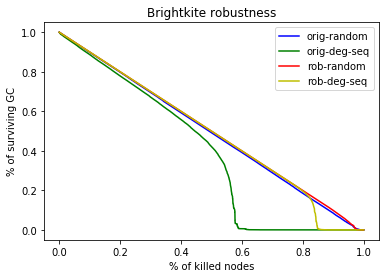

In [11]:
# read the files with the points of the robustness curves and plot the robustness curves

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages

# read the data from the respective files, putting everything into a dict
# each element in the dict stores the two vectors with the data for the corresponding curve
bk = {}
bk["or_rand"] = read_xy("Facebook/fb_orig_frac_random.txt")
bk["or_deg_seq"] = read_xy("Facebook/fb_orig_frac_deg_seq.txt")
bk["rob_rand"] = read_xy("Facebook/fb_rob_frac_random.txt")
bk["rob_deg_seq"] = read_xy("Facebook/fb_rob_frac_deg_seq.txt")

# plot the 4 curves in the same plot
_ = plt.plot(bk["or_rand"][0], bk["or_rand"][1], 'b-', label = "orig-random")
_ = plt.plot(bk["or_deg_seq"][0], bk["or_deg_seq"][1], 'g-', label = "orig-deg-seq")
_ = plt.plot(bk["rob_rand"][0], bk["rob_rand"][1], 'r-', label = "rob-random")
_ = plt.plot(bk["rob_deg_seq"][0], bk["rob_deg_seq"][1], 'y-', label = "rob-deg-seq")
_ = plt.xlabel("% of killed nodes")
_ = plt.ylabel("% of surviving GC")
_ = plt.title("Brightkite robustness")
_ = plt.legend()

# save the plot to a PDF file
pdf_file = PdfPages('fb_robustness.pdf')
plt.savefig(pdf_file, format="pdf")
pdf_file.close()

In [12]:
# read the files with the points of the robustness curves and plot the robustness curves

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages

# read the data from the respective files, putting everything into a dict
# each element in the dict stores the two vectors with the data for the corresponding curve
bk = {}
bk["or_deg_sim"] = read_xy("Facebook/fb_orig_frac_deg_sim.txt")
bk["or_module_based"] = read_xy("Facebook/fb_orig_frac_module_based.txt")
bk["rob_deg_sim"] = read_xy("Facebook/fb_rob_frac_deg_sim.txt")
bk["rob_module_based"] = read_xy("Facebook/fb_rob_frac_module_based.txt")

# plot the 4 curves in the same plot
_ = plt.plot(bk["or_deg_sim"][0], bk["or_deg_sim"][1], 'c-', label = "orig-deg-sim")
_ = plt.plot(bk["or_module_based"][0], bk["or_module_based"][1], 'm-', label = "orig-module_based")
_ = plt.plot(bk["rob_deg_sim"][0], bk["rob_deg_sim"][1], 'g-', label = "rob-deg-sim")
_ = plt.plot(bk["rob_module_based"][0], bk["rob_module_based"][1], 'y-', label = "rob-module_based")
_ = plt.xlabel("% of killed nodes")
_ = plt.ylabel("% of surviving GC")
_ = plt.title("youtube robustness - sim")
_ = plt.legend()

# save the plot to a PDF file
pdf_file = PdfPages('YT_robustness_sim.pdf')
plt.savefig(pdf_file, format="pdf")
pdf_file.close()

/home/osboxes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'U' mode is deprecated
  # This is added back by InteractiveShellApp.init_path()


FileNotFoundError: [Errno 2] No such file or directory: 'Facebook/fb_orig_frac_module_based.txt'